## Imports

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [13]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.train_model_dcec import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10

### Loading the pre-processed data

Data: Extracted and Pre-processed Patches (each patch containing a sugarbeet field)

Dimensions: (N, T, C, H, W) = (N, 7, 10, 64, 64)

In [14]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers_train, acquisition_dates_train, patch_tensor_train, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'b10', method='sin-cos')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'b10', method='sin-cos')
patch_tensor_train.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 10, 64, 64]), torch.Size([48, 7, 10, 64, 64]))

Dictionary for subpatch-to-patch mapping of reconstructed images

In [15]:
old_images_train = {fn: img for fn, img in zip(field_numbers_train, images_visualisation_train)}
old_images_eval = {fn: img for fn, img in zip(field_numbers_eval, images_visualisation_eval)}

In [16]:
acq_dict_train = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_train)}
acq_dict_eval = {fn: date for fn, date in zip(field_numbers_train, acquisition_dates_eval)}

In [17]:
# train_tensor, test_tensor, train_field_numbers, test_field_numbers = train_test_split(
#     patch_tensor_train, field_numbers_train, test_size=1-config.ae_train_test_ratio, random_state=42
# )

# dataloader_train = create_data_loader(train_tensor, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
# dataloader_test = create_data_loader(test_tensor, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
# dataloader_eval = create_data_loader(patch_tensor_eval, field_numbers_eval, batch_size=config.ae_batch_size, shuffle=False)

### Create Sub-Patches

In [18]:
train_subpatches, train_subpatch_coords = non_overlapping_sliding_window(patch_tensor_train, field_numbers_train, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
eval_subpatches, eval_subpatch_coords = non_overlapping_sliding_window(patch_tensor_eval, field_numbers_eval, patch_size=config.subpatch_size, num_encoding_channels=config.num_encoding_channels)
train_subpatches.shape, eval_subpatches.shape

(torch.Size([54623, 7, 10, 4, 4]), torch.Size([1197, 7, 10, 4, 4]))

Get field numbers and co-ordinates as string

In [19]:
train_coord_dataloader = get_string_fielddata(train_subpatch_coords)
eval_coord_dataloader = get_string_fielddata(eval_subpatch_coords)
train_coord_dataloader[0]

'1167134.0_24_28'

### Split Unlabeled data into 'train' and 'test' and create  Data Loaders

In [20]:
train_subpatches_dl, test_subpatches, train_field_numbers, test_field_numbers = train_test_split(
    train_subpatches, train_coord_dataloader, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader(train_subpatches_dl, train_field_numbers, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader(test_subpatches, test_field_numbers, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader(eval_subpatches, eval_coord_dataloader, batch_size=config.ae_batch_size, shuffle=False)

## Architecture 1: Conv3D Autoencoder

### Architecture

Input Data: ( N x C x D x H x W )

In [31]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)


    def forward(self, x):
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

### Training

In [32]:
device = 'cuda'
epochs = 50
lr = 0.01
momentum = 0.9
latent_dim = 32
channels = 10
time_steps = 7
optimizer = 'SGD'
weight_decay = 0.01
patch_size = config.subpatch_size

model = Conv3DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv3DAutoencoder(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [33]:
trained_model, train_losses, test_losses = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, weight_decay=weight_decay, device=device)

Time taken per epoch: 10.0529 seconds
Epoch 1/50, Train Loss: 0.007463, Test Loss: 0.003913
Time taken per epoch: 10.1153 seconds
Epoch 2/50, Train Loss: 0.003776, Test Loss: 0.003680
Time taken per epoch: 10.1490 seconds
Epoch 3/50, Train Loss: 0.003634, Test Loss: 0.003592
Time taken per epoch: 10.1246 seconds
Epoch 4/50, Train Loss: 0.003569, Test Loss: 0.003546
Time taken per epoch: 10.1622 seconds
Epoch 5/50, Train Loss: 0.003536, Test Loss: 0.003521
Time taken per epoch: 10.0994 seconds
Epoch 6/50, Train Loss: 0.003517, Test Loss: 0.003507
Time taken per epoch: 10.0546 seconds
Epoch 7/50, Train Loss: 0.003504, Test Loss: 0.003497
Time taken per epoch: 10.1283 seconds
Epoch 8/50, Train Loss: 0.003496, Test Loss: 0.003490
Time taken per epoch: 10.0702 seconds
Epoch 9/50, Train Loss: 0.003490, Test Loss: 0.003486
Time taken per epoch: 10.2591 seconds
Epoch 10/50, Train Loss: 0.003485, Test Loss: 0.003480
Time taken per epoch: 10.2682 seconds
Epoch 11/50, Train Loss: 0.003481, Test L

### Evaluation

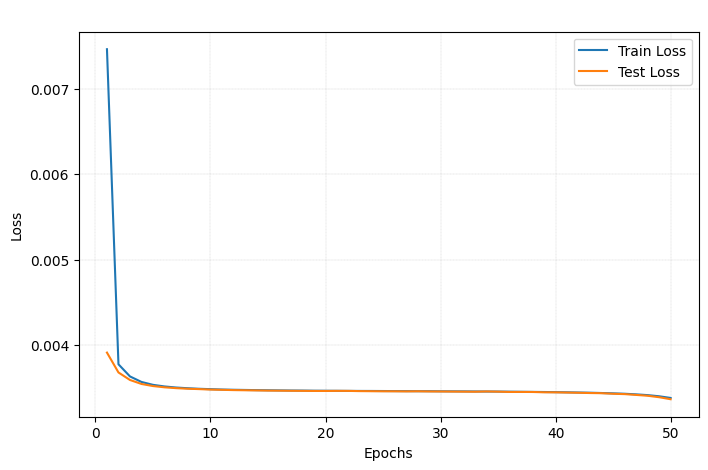

In [34]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training

In [35]:
# with open(config.kmeans_ae_3D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [36]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_3D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [38]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [39]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=21)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [40]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 0
Accuracy: 60.66
Precision: 61.22
Recall: 85.71
F1-score: 71.43
F2-score: 79.37


Save Models

In [43]:
# with open(config.ae_3d_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [44]:
# with open(config.kmeans_ae_3D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

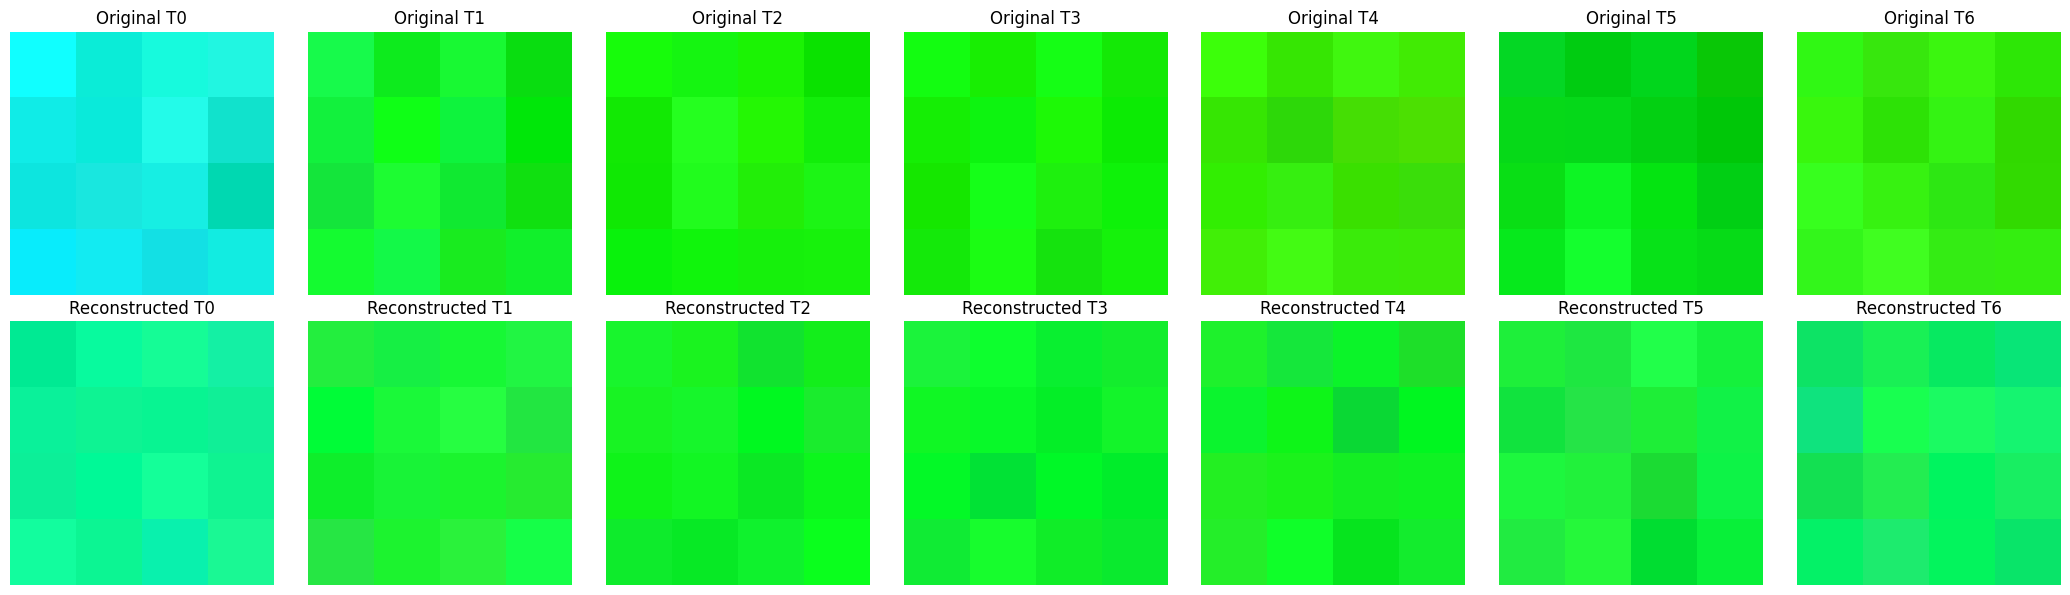

In [55]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

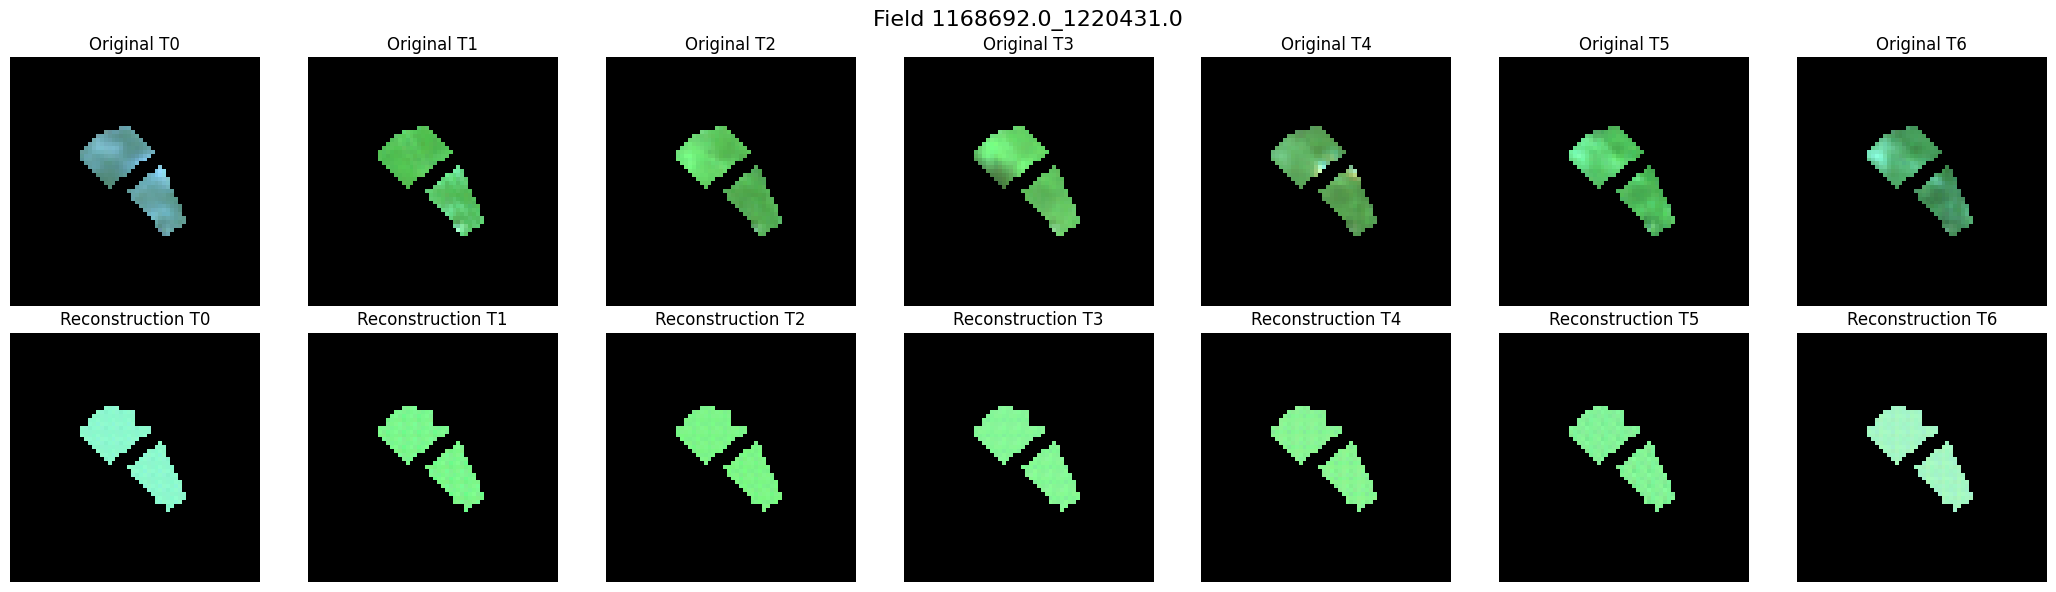

In [61]:
plot_reconstructed_patches_temporal(trained_model,dataloader_eval,old_images_eval, 1, device)

## Architecture 2: Conv2D Autoencoder with Time as Channels

### Architecture

In [81]:
class Conv2DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        
        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as additional channels (B, C * D, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        # print(x.shape)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return z, x_reconstructed

### Training

In [82]:
device = 'cuda'
epochs = 50
lr = 0.01
latent_dim=32
channels = 10
optimizer = 'SGD'
momentum = 0.9
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DAutoencoder(channels, time_steps, latent_dim, patch_size)
device = torch.device(device)  
model.to(device)

Conv2DAutoencoder(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [83]:
trained_model, train_losses, test_losses = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Time taken per epoch: 3.0377 seconds
Epoch 1/50, Train Loss: 0.018016, Test Loss: 0.005265
Time taken per epoch: 3.0077 seconds
Epoch 2/50, Train Loss: 0.004752, Test Loss: 0.004349
Time taken per epoch: 2.9370 seconds
Epoch 3/50, Train Loss: 0.004098, Test Loss: 0.003896
Time taken per epoch: 2.9819 seconds
Epoch 4/50, Train Loss: 0.003776, Test Loss: 0.003682
Time taken per epoch: 2.9772 seconds
Epoch 5/50, Train Loss: 0.003630, Test Loss: 0.003588
Time taken per epoch: 3.0505 seconds
Epoch 6/50, Train Loss: 0.003567, Test Loss: 0.003548
Time taken per epoch: 2.9755 seconds
Epoch 7/50, Train Loss: 0.003539, Test Loss: 0.003529
Time taken per epoch: 2.9856 seconds
Epoch 8/50, Train Loss: 0.003524, Test Loss: 0.003517
Time taken per epoch: 3.0451 seconds
Epoch 9/50, Train Loss: 0.003516, Test Loss: 0.003510
Time taken per epoch: 2.9676 seconds
Epoch 10/50, Train Loss: 0.003509, Test Loss: 0.003505
Time taken per epoch: 2.9587 seconds
Epoch 11/50, Train Loss: 0.003505, Test Loss: 0.0035

### Evaluation

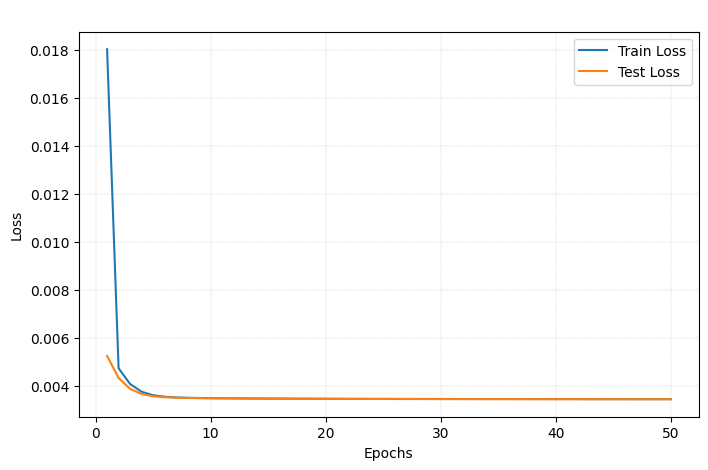

In [84]:
plot_loss(train_losses, test_losses, title=" ")

##### NOTE: Load Saved Model to skip Training the model

In [106]:
# with open(config.kmeans_ae_2D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [107]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.ae_2D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [103]:
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [104]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=22)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [105]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 62.3
Precision: 65.79
Recall: 71.43
F1-score: 68.49
F2-score: 70.22


Save Models

In [101]:
# with open(config.ae_2D_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [73]:
# with open(config.kmeans_ae_2D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

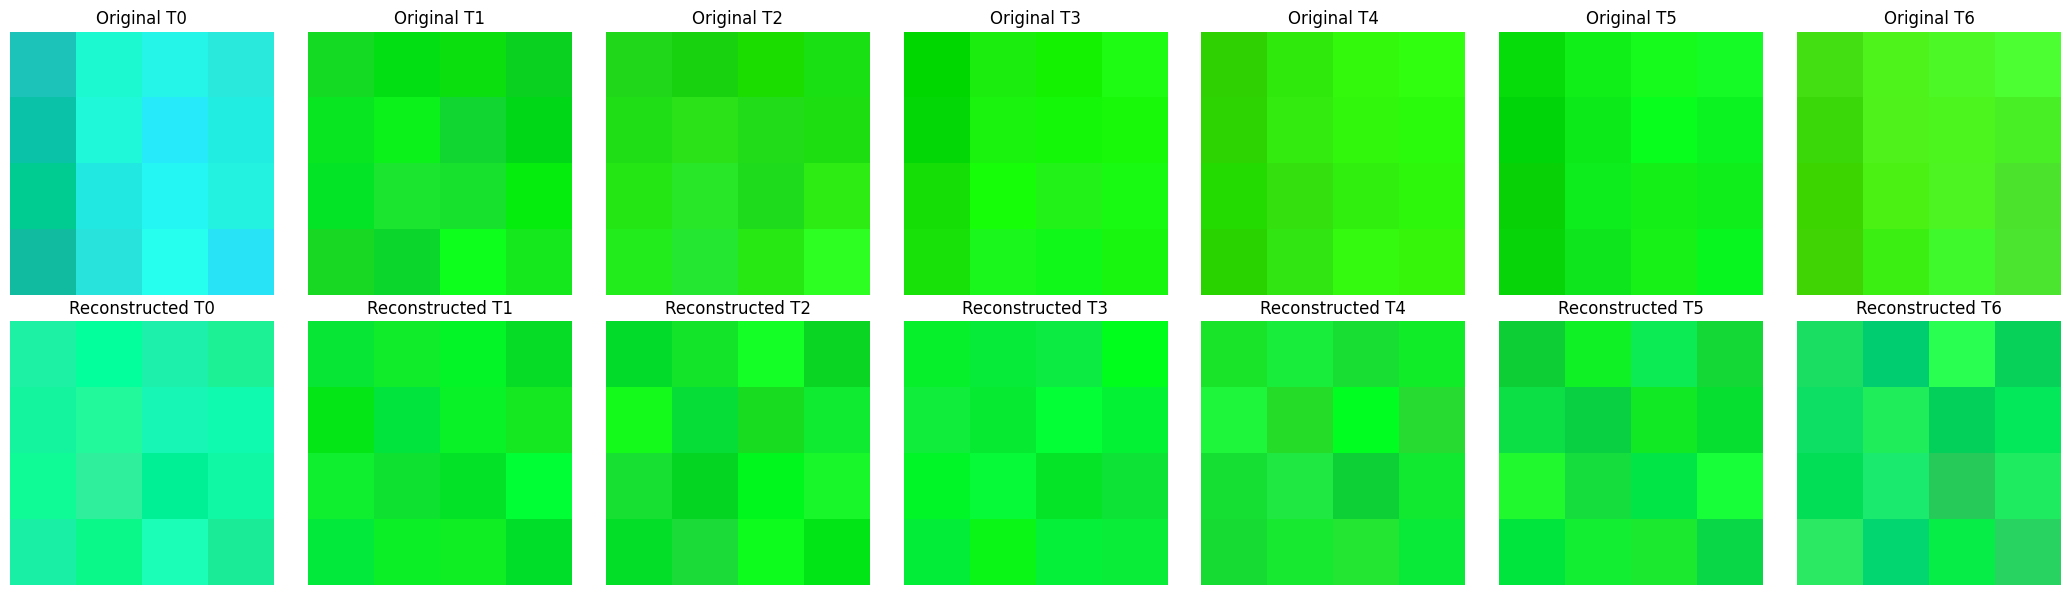

In [78]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_train, 1, device)

Map subpatch-level to patches and Visualise Patch level reconstructions

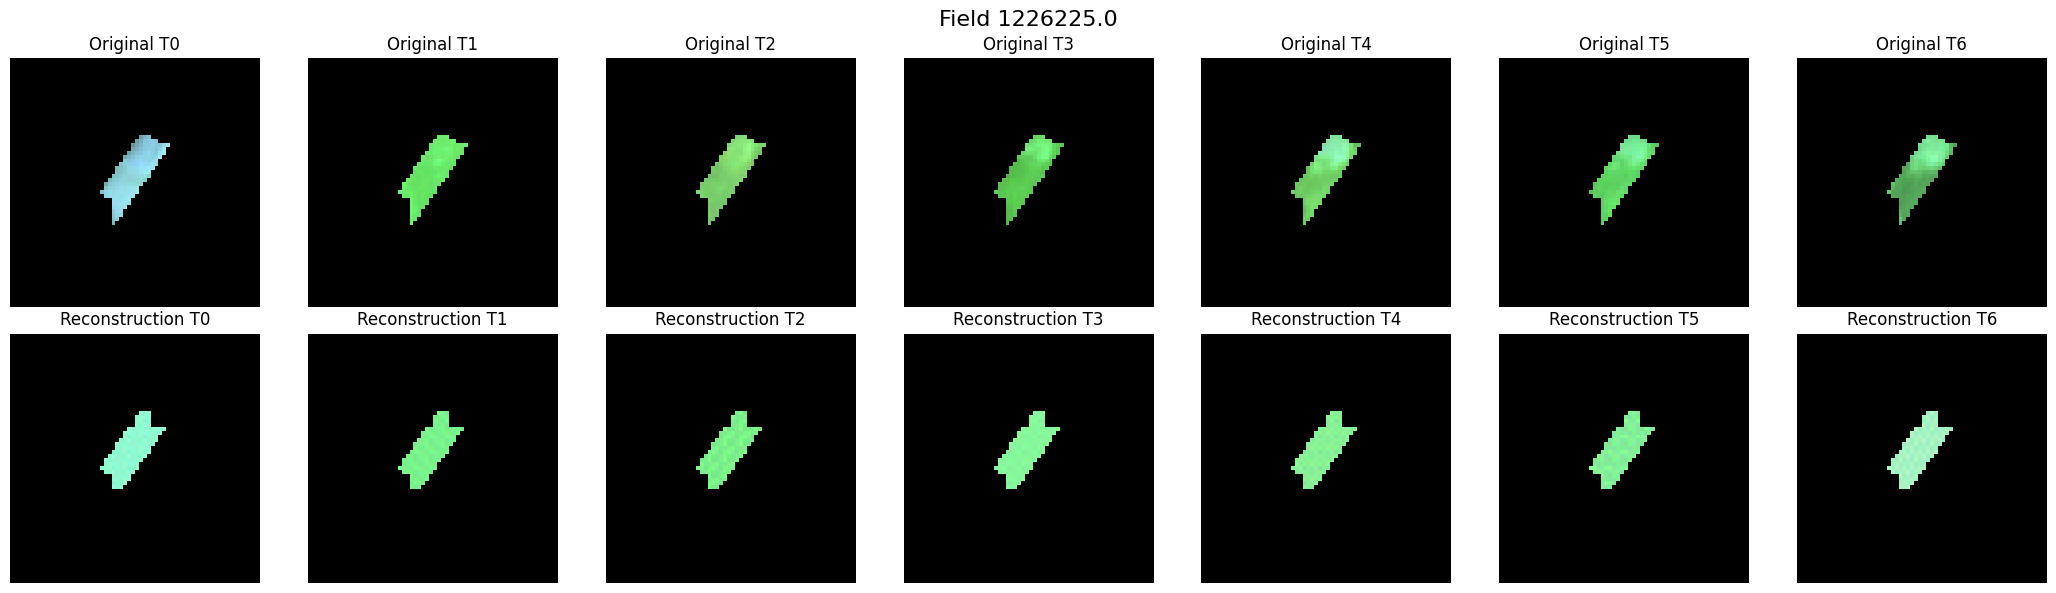

In [124]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device)

## Architecture 3: Conv3D Variationl Autoencoder

### Architecture

In [135]:
class Conv3DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * time_steps * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)
        self.fc_logvar = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * time_steps * patch_size * patch_size)

        # --- 3D Deconvolutions ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape for 3D Deconvolutions ---
        x = self.unflatten(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)

        return mu, log_var, z, x_reconstructed


### Training

In [139]:
device = 'cuda'
epochs = 50
lr = 0.0001
optimizer = 'Adam'
latent_dim=32
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv3DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv3DVAE(
  (conv1): Conv3d(10, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28672, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=28672, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 7, 4, 4))
  (deconv1): ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (deconv3): ConvTranspose3d(64, 10, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [140]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 321.2686, Train KL Loss: 10.3509
  Test Recon Loss: 153.1959, Test KL Loss: 19.9564
Epoch 2/50
  Train Recon Loss: 106.2012, Train KL Loss: 20.8701
  Test Recon Loss: 84.6687, Test KL Loss: 21.0424
Epoch 3/50
  Train Recon Loss: 72.3390, Train KL Loss: 21.7099
  Test Recon Loss: 59.5060, Test KL Loss: 22.4308
Epoch 4/50
  Train Recon Loss: 50.0624, Train KL Loss: 22.8493
  Test Recon Loss: 47.0630, Test KL Loss: 21.8056
Epoch 5/50
  Train Recon Loss: 44.6242, Train KL Loss: 21.8455
  Test Recon Loss: 41.3750, Test KL Loss: 21.2686
Epoch 6/50
  Train Recon Loss: 40.9101, Train KL Loss: 21.1374
  Test Recon Loss: 38.3768, Test KL Loss: 21.0134
Epoch 7/50
  Train Recon Loss: 37.7662, Train KL Loss: 20.5768
  Test Recon Loss: 35.2074, Test KL Loss: 20.5321
Epoch 8/50
  Train Recon Loss: 35.0240, Train KL Loss: 20.1265
  Test Recon Loss: 34.2612, Test KL Loss: 20.4564
Epoch 9/50
  Train Recon Loss: 33.2628, Train KL Loss: 19.8678
  Test Recon Loss: 33.5698, Te

### Evaluation

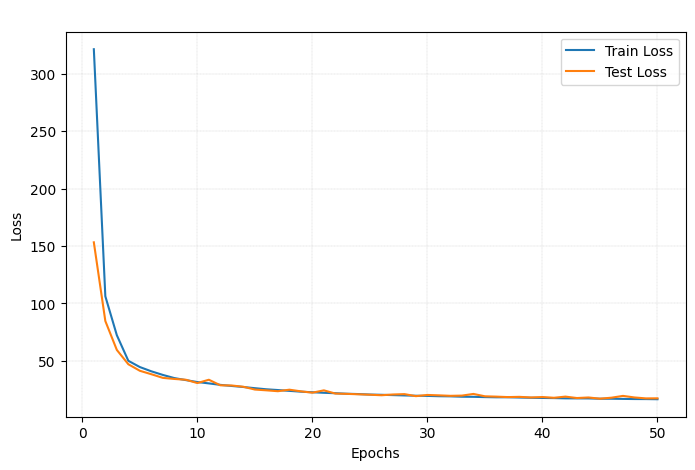

In [141]:
plot_loss(train_recon_losses, test_recon_losses, " ")

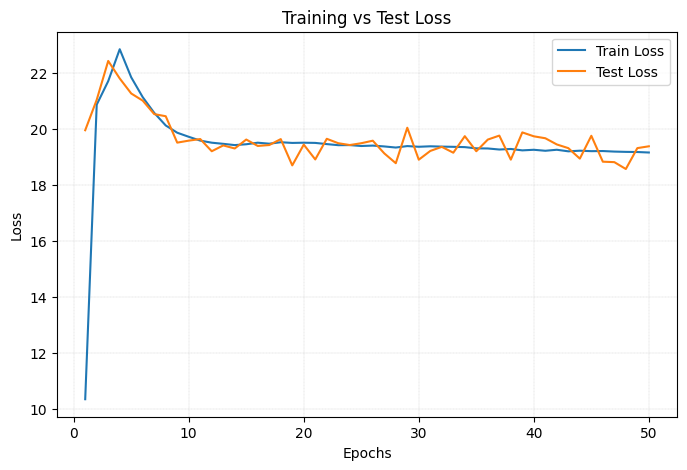

In [142]:
plot_loss(train_kl_losses, test_kl_losses)

##### NOTE: Load Saved Model to skip Training the model

In [143]:
# with open(config.kmeans_vae_3D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [144]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.vae_3D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [145]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [148]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=23)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [149]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 55.74
Precision: 59.52
Recall: 71.43
F1-score: 64.94
F2-score: 68.68


Save Models

In [150]:
# with open(config.vae_3D_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [151]:
# with open(config.kmeans_vae_3D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

Visualise Sub-patch-level Reconstructions => Random Image

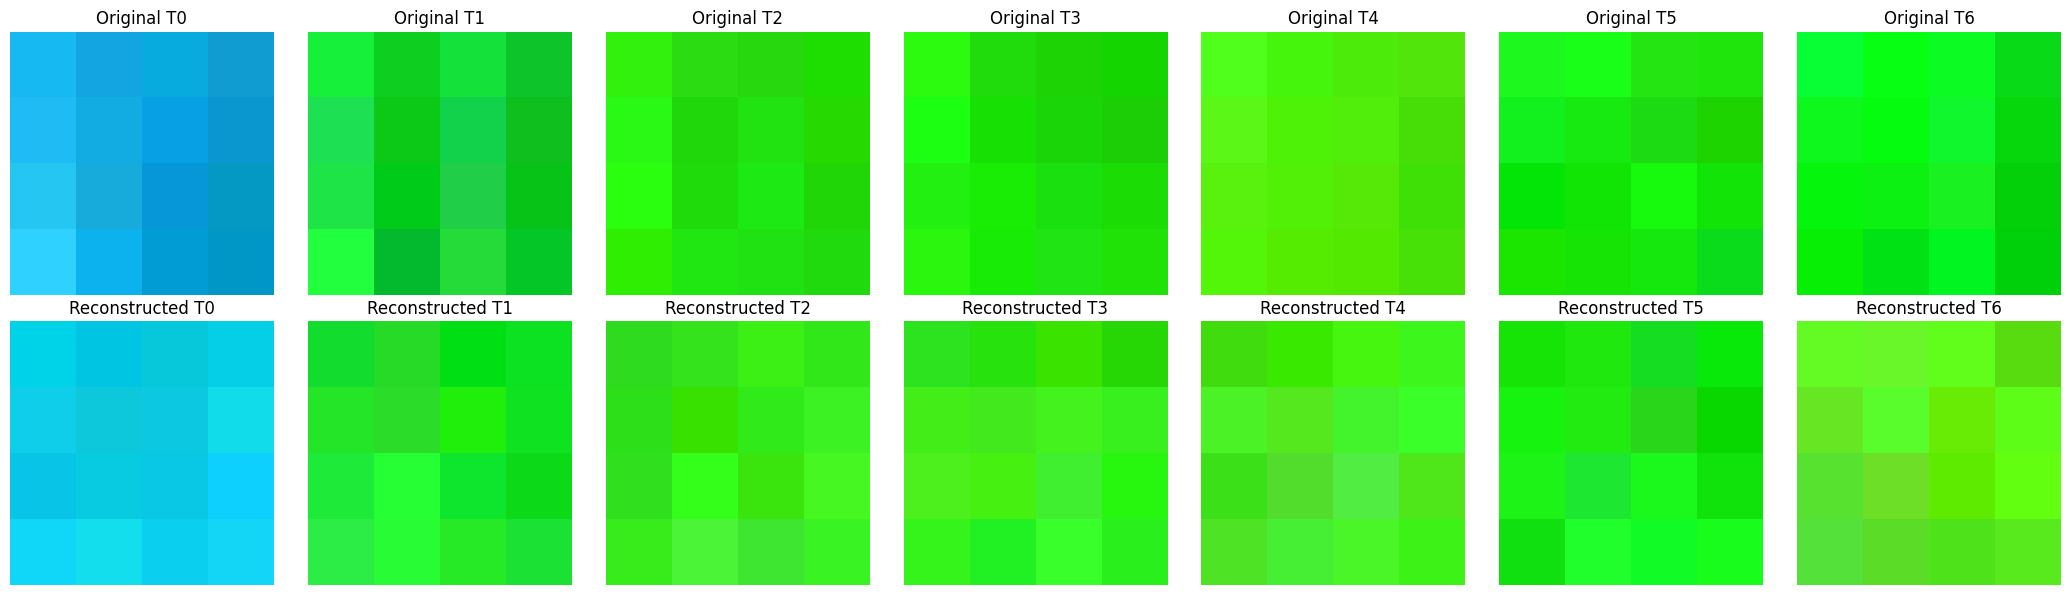

In [153]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_eval, 1, device, model_type='vae')

Map subpatch-level to patches and Visualise Patch level reconstructions => Random Image

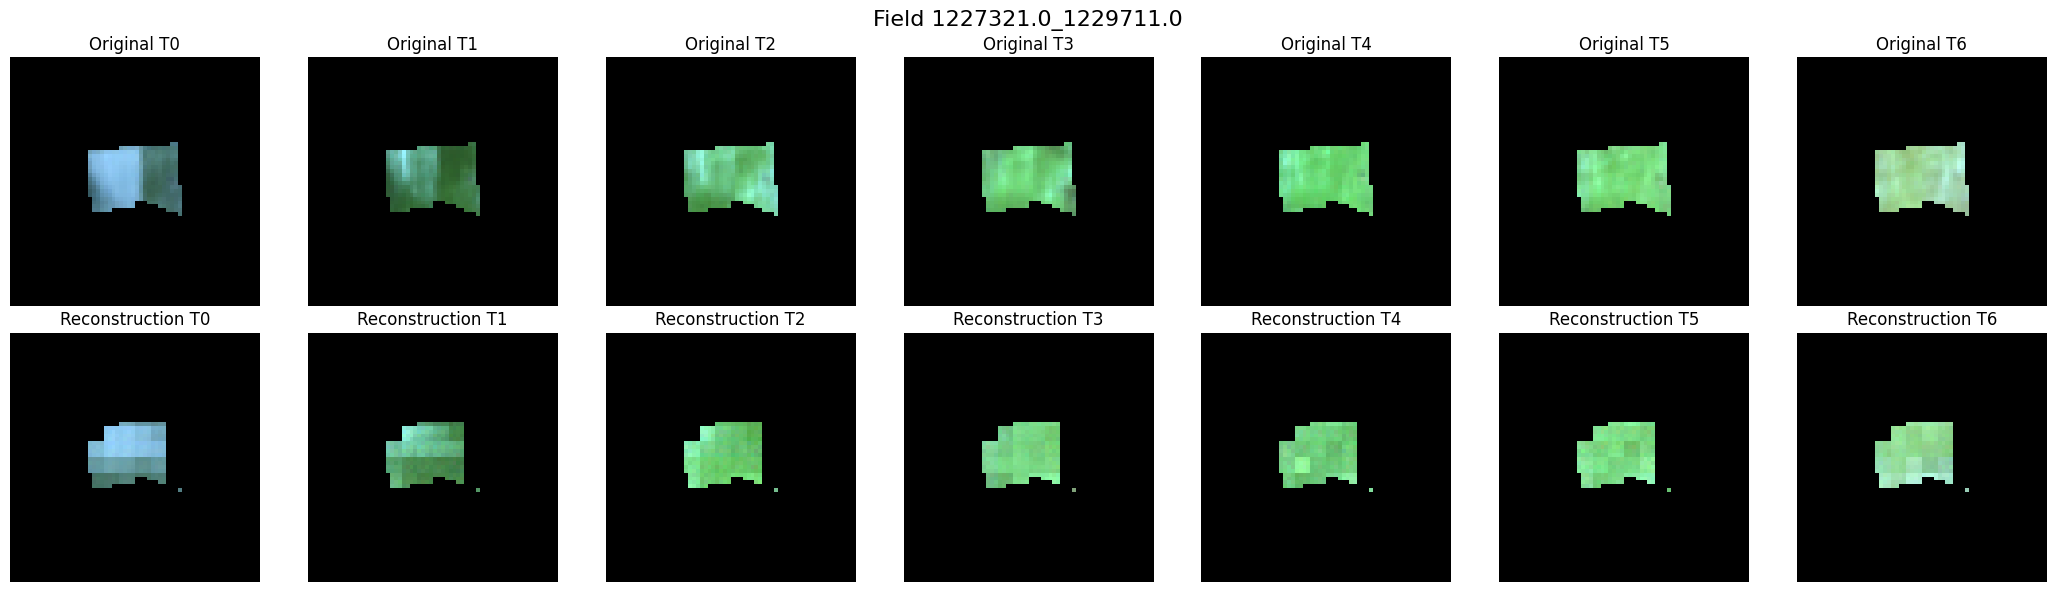

In [162]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device, model_type='vae')

## Architecture 4: Conv2D Variational Autoencoder

### Architecture

In [163]:
class Conv2DVAE(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv2DVAE, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels

        # --- Encoder (2D Convolutions, treating time steps as channels) ---
        self.conv1 = nn.Conv2d(in_channels * time_steps, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size, 512)
        self.fc_mu = nn.Linear(512, latent_size)      # Mean
        self.fc_logvar = nn.Linear(512, latent_size)  # Log Variance

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size)

        # --- 2D Deconvolutions ---
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, in_channels * time_steps, kernel_size=3, stride=1, padding=1)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        # --- Encoder ---
        b, c, t, h, w = x.shape
        x = x.reshape(b, c * t, h, w)      # Imp: Time steps as channels (B, C * T, H, W)
        # print(x.shape)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        # --- Reparameterization Trick ---
        z = self.reparameterize(mu, log_var)

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- 2D Deconvolutions ---
        x = x.view(b, 256, h, w)        
        # print(x.shape)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)
        # print(x.shape)

        # --- Reshape to B x C x D x H x W ---
        x_reconstructed = x.view(b, self.in_channels, self.time_steps, h, w) 

        return mu, log_var, z, x_reconstructed

### Training

In [168]:
device = 'cuda'
epochs = 50
lr = 0.001
latent_dim=32
optimizer='Adam'
channels = 10
time_steps = 7
patch_size = config.subpatch_size

model = Conv2DVAE(channels, time_steps, latent_dim, config.subpatch_size)
device = torch.device(device)  
model.to(device)

Conv2DVAE(
  (conv1): Conv2d(70, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=4096, bias=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv3): ConvTranspose2d(64, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

##### Note: To skip training, skip the next cell and go to evalaution section (just after the loss curves), and uncomment and run the cells for loading the saved models.

In [169]:
trained_model, train_recon_losses, train_kl_losses, test_recon_losses, test_kl_losses  = train_model_vae(model, dataloader_train, dataloader_test, epochs=epochs, optimizer=optimizer, lr=lr, device=device)

Epoch 1/50
  Train Recon Loss: 283.0468, Train KL Loss: 3.0159
  Test Recon Loss: 189.6167, Test KL Loss: 3.0414
Epoch 2/50
  Train Recon Loss: 164.6917, Train KL Loss: 5.1215
  Test Recon Loss: 148.4953, Test KL Loss: 5.1832
Epoch 3/50
  Train Recon Loss: 121.4148, Train KL Loss: 7.4361
  Test Recon Loss: 111.3698, Test KL Loss: 7.6665
Epoch 4/50
  Train Recon Loss: 95.7625, Train KL Loss: 10.1330
  Test Recon Loss: 77.5372, Test KL Loss: 11.2377
Epoch 5/50
  Train Recon Loss: 71.0151, Train KL Loss: 11.7415
  Test Recon Loss: 66.2361, Test KL Loss: 10.8289
Epoch 6/50
  Train Recon Loss: 63.8567, Train KL Loss: 11.4950
  Test Recon Loss: 62.3920, Test KL Loss: 11.5551
Epoch 7/50
  Train Recon Loss: 60.7512, Train KL Loss: 11.6101
  Test Recon Loss: 65.7656, Test KL Loss: 11.0032
Epoch 8/50
  Train Recon Loss: 58.2814, Train KL Loss: 11.7467
  Test Recon Loss: 59.3900, Test KL Loss: 11.5793
Epoch 9/50
  Train Recon Loss: 56.6394, Train KL Loss: 11.8756
  Test Recon Loss: 56.8872, Test 

### Evaluation

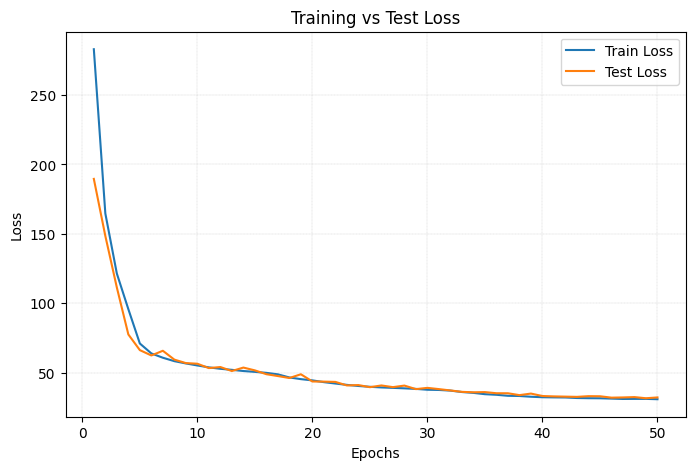

In [170]:
plot_loss(train_recon_losses, test_recon_losses)

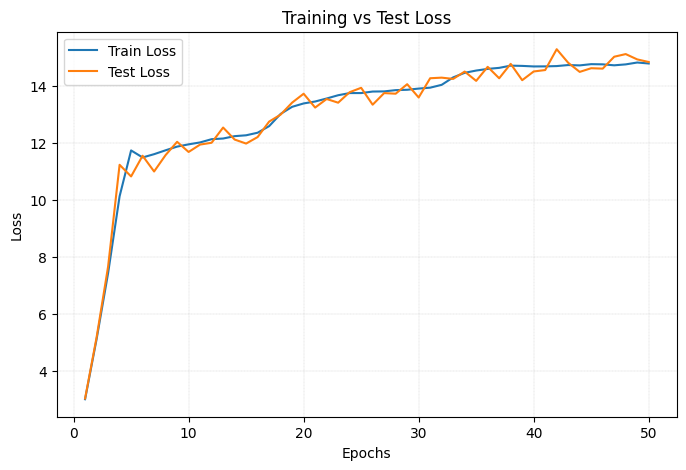

In [171]:
plot_loss(train_kl_losses, test_kl_losses)

##### NOTE: Load Saved Model to skip Training the model

In [ ]:
# with open(config.kmeans_vae_2D_path, 'rb') as file:
#     kmeans = pickle.load(file)

In [ ]:
# trained_model = Conv3DAutoencoder(channels, time_steps, latent_dim, config.subpatch_size)

# with open(config.vae_2D_path, 'rb') as file:
#     trained_model = pickle.load(file)

##### Metrics

Use trained Encoder part to get the features for train, test and evaluation Data

In [172]:
train_features, train_coord_dl = extract_features_vae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_vae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_vae(trained_model, dataloader_eval, device)

train_features = train_features.cpu()
test_features = test_features.cpu()
eval_features = eval_features.cpu()

combined_train_features = torch.cat((train_features, test_features), dim=0)
combined_train_coords = train_coord_dl + test_coord_dl

K-means on extracted features

In [173]:
kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=24)

train_subpatch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy

In [174]:
disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dl, eval_subpatch_predictions, config.labels_path, config.subpatch_to_patch_threshold)
print("Disease cluster:", disease)
print("Accuracy:",acc)
print("Precision:",precision)
print("Recall:",recall)
print("F1-score:",f1_score)
print("F2-score:", f2_score)

Disease cluster: 1
Accuracy: 55.74
Precision: 61.11
Recall: 62.86
F1-score: 61.97
F2-score: 62.5


Save Models

In [175]:
# with open(config.vae_2D_path, 'wb') as file:
#     pickle.dump(trained_model, file)

In [176]:
# with open(config.kmeans_vae_2D_path, 'wb') as file:
#     pickle.dump(kmeans, file)

### Visualisations

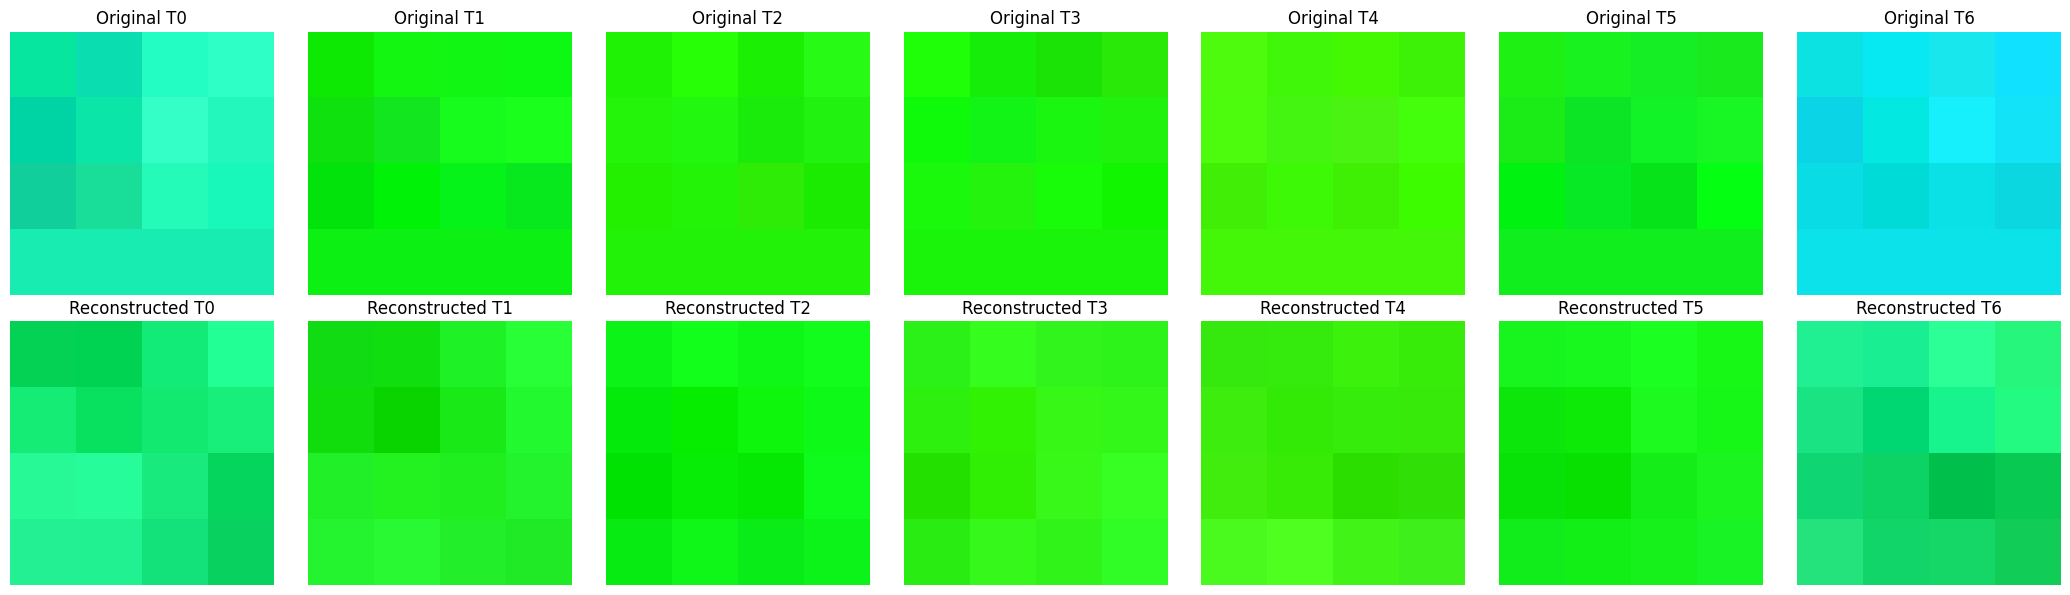

In [182]:
plot_reconstructed_subpatches_temporal(trained_model, dataloader_eval, 1, device, model_type='vae')

Map subpatch-level to patches and Visualise Patch level reconstructions

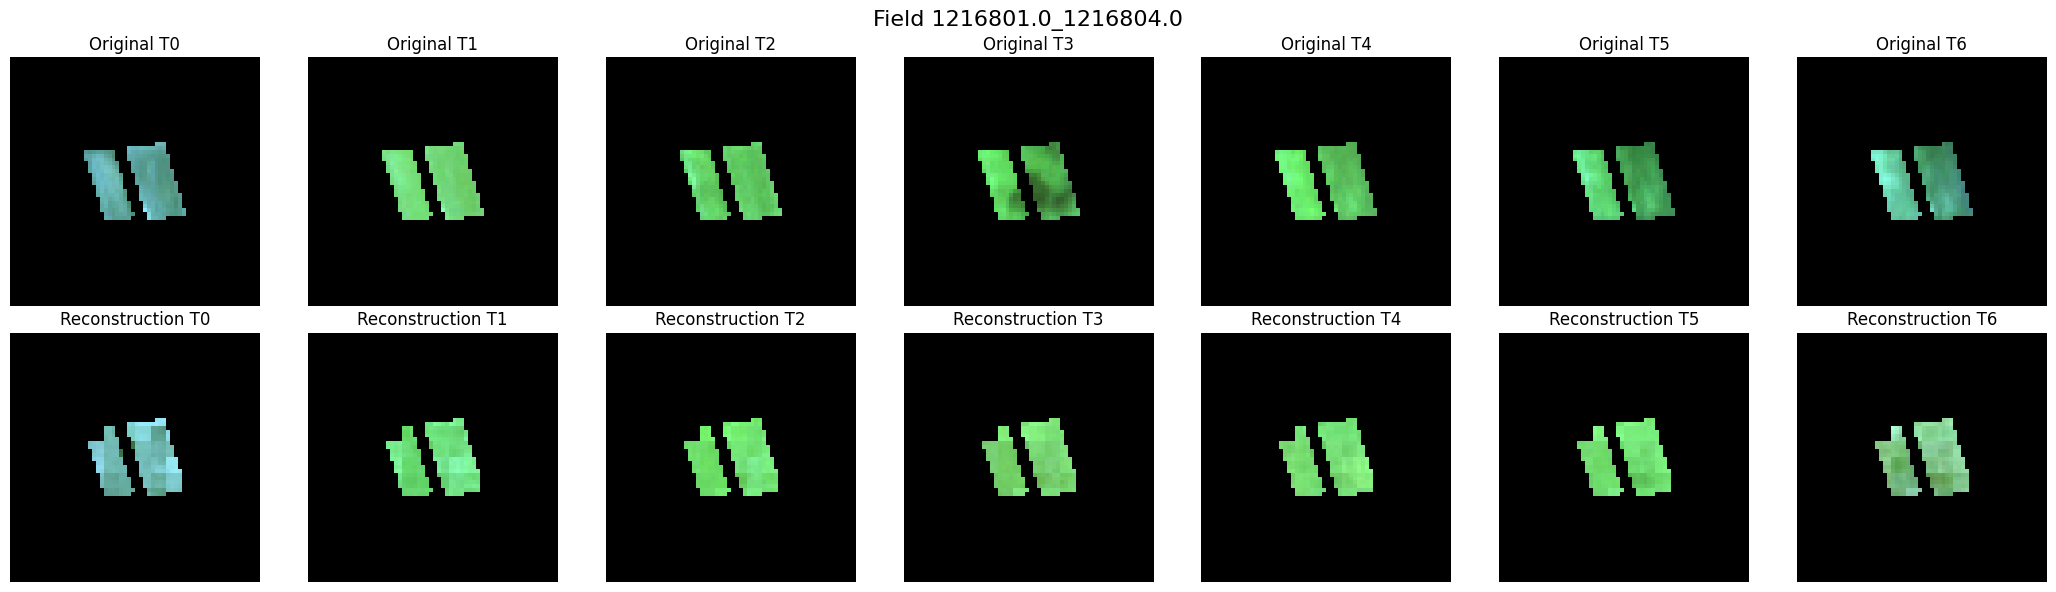

In [184]:
plot_reconstructed_patches_temporal(trained_model, dataloader_eval, old_images_eval, 1, device, model_type='vae')